# CAFA-6 Protein Function Prediction: The Ensemble Era 

Welcome to this comprehensive pipeline for the **CAFA-6 Competition**!

In this notebook, we will build a powerful, **multi-model ensemble** system to predict protein functions (GO terms) from amino acid sequences. We will combine the strengths of three state-of-the-art Protein Language Models (pLMs):

1.  **ProtBERT**  (Rostlab)
2.  **ESM-2**  (Meta AI)

###  Key Features
-   **Visual EDA**: Beautiful plots to understand our data.
-   **GPU Optimization**: Efficient embedding generation.
-   **Ensemble Learning**: Averaging predictions for robustness.
-   **Clean Code**: Structured, commented, and easy to follow.

Let's dive in! 

In [2]:
!pip install biopython --quiet # I was getting an error so that's why doing this

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 35.4 MB/s eta 0:00:0000:0100:01


In [3]:
# Imports & Setup
import os
import sys
import gc
import json
import re
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel, T5EncoderModel
from Bio import SeqIO
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
from torch.utils.data import TensorDataset, DataLoader
from multiprocessing import Pool, cpu_count
import glob
# TPU SUPPORT (ADDED
USE_TPU = False
try:
    import torch_xla
    import torch_xla.core.xla_model as xm
    import torch_xla.distributed.parallel_loader as pl
    import torch_xla.debug.metrics as met
    import torch_xla.utils.utils as xu
    USE_TPU = True
except ImportError:
    USE_TPU = False

#  Plotting Style
sns.set_theme(style="whitegrid", palette="viridis")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 12

#  Paths
INPUT_DIR = "/kaggle/input/cafa-6-protein-function-prediction/"
WORKING_DIR = "/kaggle/working/"
OUTPUT_LABELS_DIR = os.path.join(WORKING_DIR, "outputs_labels")
EMBEDDINGS_DIR = os.path.join(WORKING_DIR, "embeddings")
MODELS_DIR = os.path.join(WORKING_DIR, "models")
os.makedirs(OUTPUT_LABELS_DIR, exist_ok=True)
os.makedirs(EMBEDDINGS_DIR, exist_ok=True)
os.makedirs(MODELS_DIR, exist_ok=True)

if USE_TPU:
    device = torch_xla.device()
    print(" TPU detected. Using device:", device)
else:
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(" Using device:", device)

2025-12-15 04:16:02.150666: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1765772162.366982      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1765772162.430188      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

AttributeError: 'MessageFactory' object has no attribute 'GetPrototype'

 Using device: cuda


## Part 1: Exploratory Data Analysis (EDA)
Before we model, we must understand. Let's load the data and visualize the sequence lengths and GO term distributions.

 Loading sequences...
 Train Sequences: 82,404
 Test Sequences: 224,309
 Train Annotations: 537,027


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


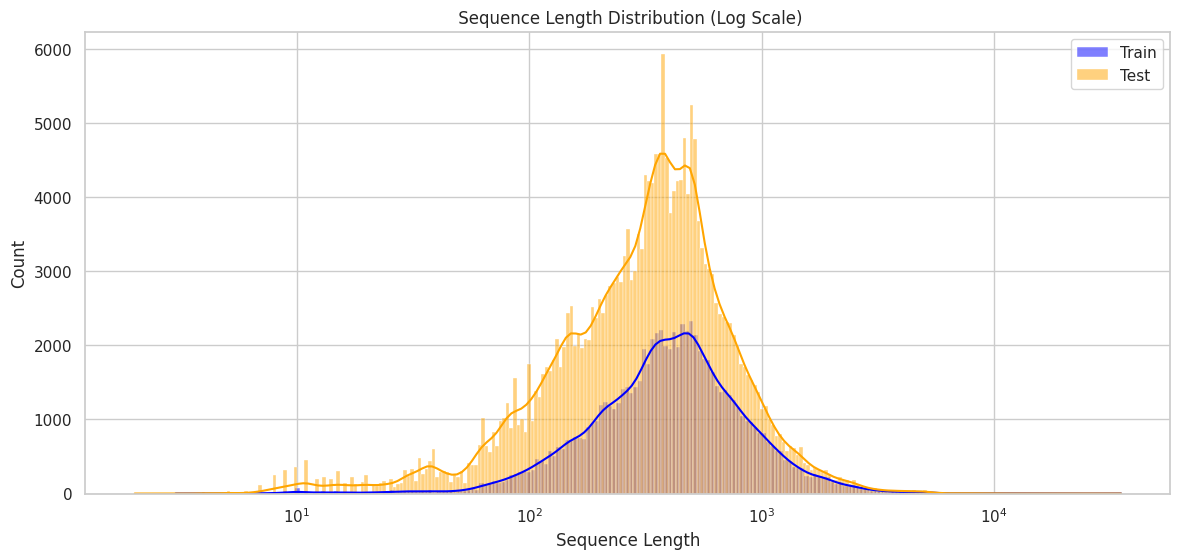

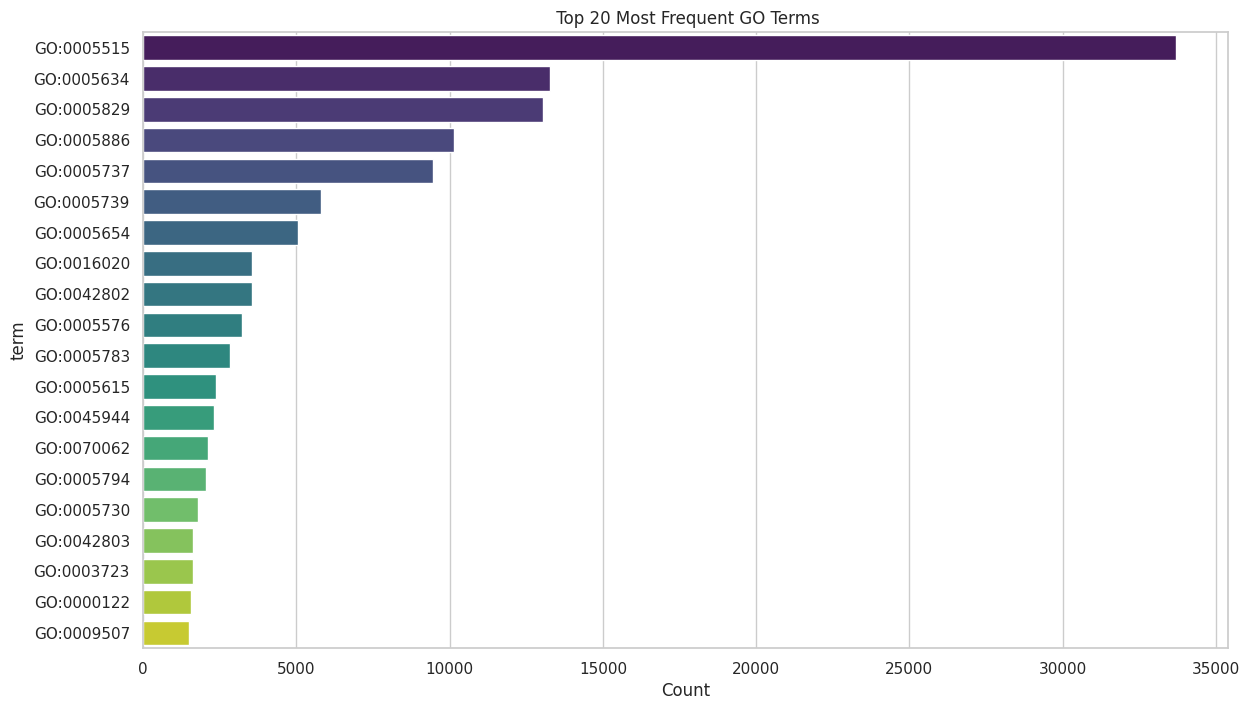

In [4]:
#  Load Data
print(" Loading sequences...")
train_seqs = {rec.id: str(rec.seq) for rec in SeqIO.parse(os.path.join(INPUT_DIR, "Train/train_sequences.fasta"), "fasta")}
test_seqs = {rec.id: str(rec.seq) for rec in SeqIO.parse(os.path.join(INPUT_DIR, "Test/testsuperset.fasta"), "fasta")}
train_terms_df = pd.read_csv(os.path.join(INPUT_DIR, "Train/train_terms.tsv"), sep="\t")

print(f" Train Sequences: {len(train_seqs):,}")
print(f" Test Sequences: {len(test_seqs):,}")
print(f" Train Annotations: {len(train_terms_df):,}")

# Plot Sequence Length Distribution
train_lens = [len(s) for s in train_seqs.values()]
test_lens = [len(s) for s in test_seqs.values()]

plt.figure(figsize=(14, 6))
sns.histplot(train_lens, color="blue", label="Train", kde=True, alpha=0.5, log_scale=True)
sns.histplot(test_lens, color="orange", label="Test", kde=True, alpha=0.5, log_scale=True)
plt.title(" Sequence Length Distribution (Log Scale)")
plt.xlabel("Sequence Length")
plt.legend()
plt.show()

#  Plot Top GO Terms
top_terms = train_terms_df['term'].value_counts().head(20)
plt.figure(figsize=(14, 8))
sns.barplot(x=top_terms.values, y=top_terms.index, palette="viridis")
plt.title(" Top 20 Most Frequent GO Terms")
plt.xlabel("Count")
plt.show()

##  Part 2: The Knowledge Graph (Gene Ontology)
Proteins functions are related! If a protein does X, and X is a subclass of Y, it also does Y. We need to parse the **Gene Ontology (GO)** graph to enforce these rules.

In [5]:
#  Parse OBO & Build Ancestors
def parse_obo(obo_file):
    terms = {}
    current_term = None
    with open(obo_file, 'r') as f:
        for line in f:
            line = line.strip()
            if line == "[Term]":
                if current_term:
                    terms[current_term['id']] = current_term
                current_term = {'is_a': [], 'namespace': ''}
            elif line.startswith("id: "):
                current_term['id'] = line[4:]
            elif line.startswith("namespace: "):
                current_term['namespace'] = line[11:]
            elif line.startswith("is_a: "):
                current_term['is_a'].append(line[6:].split(' ! ')[0])
    if current_term:
        terms[current_term['id']] = current_term
    return terms

go_terms = parse_obo(os.path.join(INPUT_DIR, "Train/go-basic.obo"))
print(f" Parsed {len(go_terms):,} GO terms.")

# Build Ancestors (Transitive Closure)
ancestors = {}
for term_id in tqdm(go_terms, desc=" Building Graph"):
    queue = [term_id]
    visited = set()
    while queue:
        curr = queue.pop(0)
        if curr in visited: continue
        visited.add(curr)
        if curr in go_terms:
            queue.extend(go_terms[curr]['is_a'])
    ancestors[term_id] = list(visited)
with open(os.path.join(OUTPUT_LABELS_DIR, "ancestors.json"), "w") as f:
    json.dump(ancestors, f)
print(" Ancestor graph saved.")

 Parsed 48,101 GO terms.


 Building Graph:   0%|          | 0/48101 [00:00<?, ?it/s]

 Ancestor graph saved.


In [6]:
def extract_uniprot_id(header):
    # Extract between first pair of pipes → sp|XXXX| or tr|XXXX|
    m = re.match(r"^[a-z]{2}\|([^|]+)\|", header)
    if m:
        return m.group(1)
    return header  # fallback

# Build mapping: extract UniProt ID for every FASTA protein
train_proteins_raw = list(train_seqs.keys())
train_proteins = [extract_uniprot_id(h) for h in train_proteins_raw]

prot_map = {pid: i for i, pid in enumerate(train_proteins)}

# Filter annotation proteins to the ones that appear in FASTA
valid_annots = train_terms_df[train_terms_df["EntryID"].isin(prot_map)]

print("Proteins in FASTA:", len(train_seqs))
print("Proteins in annotations:", len(train_terms_df))
print("Overlap:", len(valid_annots))

used_terms = set(train_terms_df["term"].unique())

terms_MF = [t for t in used_terms if t in go_terms and go_terms[t]['namespace'] == 'molecular_function']
terms_BP = [t for t in used_terms if t in go_terms and go_terms[t]['namespace'] == 'biological_process']
terms_CC = [t for t in used_terms if t in go_terms and go_terms[t]['namespace'] == 'cellular_component']


term_maps = {
    'MF': {str(i): t for i, t in enumerate(terms_MF)},
    'BP': {str(i): t for i, t in enumerate(terms_BP)},
    'CC': {str(i): t for i, t in enumerate(terms_CC)}
}

with open(os.path.join(OUTPUT_LABELS_DIR, "maps.json"), "w") as f:
    json.dump(term_maps, f)

for ns, terms_list in [('MF', terms_MF), ('BP', terms_BP), ('CC', terms_CC)]:

    go_to_idx = {t: i for i, t in enumerate(terms_list)}

    df_ns = valid_annots[valid_annots["term"].isin(terms_list)]
    
    p_idx = df_ns["EntryID"].map(prot_map).values
    t_idx = df_ns["term"].map(go_to_idx).values

    mat = sparse.coo_matrix(
        (np.ones(len(p_idx)), (p_idx, t_idx)),
        shape=(len(train_proteins), len(terms_list)),
        dtype=np.int8
    ).tocsr()

    sparse.save_npz(os.path.join(OUTPUT_LABELS_DIR, f"labels_{ns}.npz"), mat)

    print(f"{ns}: proteins={mat.shape[0]}, terms={mat.shape[1]}, nonzero={mat.nnz}")


Proteins in FASTA: 82404
Proteins in annotations: 537027
Overlap: 537027
MF: proteins=82404, terms=6616, nonzero=128452
BP: proteins=82404, terms=16858, nonzero=250805
CC: proteins=82404, terms=2651, nonzero=157770


In [7]:
#cheking the .npz files
for ns in ["MF", "BP", "CC"]:
    mat = sparse.load_npz(os.path.join(OUTPUT_LABELS_DIR, f"labels_{ns}.npz"))
    print(ns, "nonzero:", mat.count_nonzero(), "shape:", mat.shape)


MF nonzero: 128452 shape: (82404, 6616)
BP nonzero: 250805 shape: (82404, 16858)
CC nonzero: 157770 shape: (82404, 2651)


##  Part 3: Feature Engineering (Embeddings)
Here I will now extract rich features from protein sequences using **three** different models. This is the secret sauce! 
We define a generic embedding function to reuse for all models.

In [8]:
def embed_sequences(model_name, seq_dict, batch_size=16, max_len=1024):

    # FORCE GPU ONLY
    if not torch.cuda.is_available():
        raise SystemExit(" GPU NOT FOUND — Cannot embed on CPU. Aborting as requested.")

    device = torch.device("cuda")
    print(" FORCING GPU:", device)

    name = model_name.lower()
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModel.from_pretrained(
            model_name,
            torch_dtype=torch.float16
        )

    model = model.to(device)
    model.eval()

    seqs = list(seq_dict.values())
    ids = list(seq_dict.keys())
    embeddings = []

    for i in tqdm(range(0, len(seqs), batch_size)):
        batch = seqs[i:i + batch_size]

        # TOKENIZATION RULES
        if "t5" in name:
            batch_tok = [" ".join(list(s)) for s in batch]
        elif "bert" in name:
            batch_tok = [" ".join(list(s)) for s in batch]
        else:
            batch_tok = batch   

        inputs = tokenizer(
            batch_tok,
            return_tensors="pt",
            padding=True,
            truncation=True,
            max_length=max_len
        ).to(device)

        with torch.no_grad():
            with torch.cuda.amp.autocast(dtype=torch.float16):

                outputs = model(**inputs)
                hidden = outputs.last_hidden_state   
                mask = inputs["attention_mask"].unsqueeze(-1).float()

                # mean pooling
                emb = (hidden * mask).sum(dim=1) / mask.sum(dim=1).clamp(min=1e-9)

        # move to CPU only at the last moment
        embeddings.append(emb.float().cpu().numpy())

        torch.cuda.empty_cache()
        gc.collect()

    return np.concatenate(embeddings), ids


**Note: I have done the embedding locally so you can check the dataset**

In [9]:
# emb_train_bert, _ = embed_sequences("Rostlab/prot_bert", train_seqs, batch_size=128)
# np.save("train_protbert.npy", emb_train_bert)
# del emb_train_bert

# emb_test_bert, test_ids = embed_sequences("Rostlab/prot_bert", test_seqs, batch_size=128)
# np.save("test_protbert.npy", emb_test_bert)
# np.save("test_ids.npy", test_ids)
# del emb_test_bert
print("Protbert embeddings saved") 

Protbert embeddings saved


In [10]:
# emb_train_esm, _ = embed_sequences("facebook/esm2_t30_150M_UR50D", train_seqs, batch_size=8)
# np.save("train_esm2.npy", emb_train_esm)
# del emb_train_esm

# emb_test_esm, _ = embed_sequences("facebook/esm2_t30_150M_UR50D", test_seqs, batch_size=8)
# np.save("test_esm2.npy", emb_test_esm)
# del emb_test_esm
print("ESM-2(150M) embeddings saved")

ESM-2(150M) embeddings saved


**I am using a different embedding function for Prot5 cause I was finding difficulty to create a single unifies one for Prott5**

**We freeze ProtT5 and generate contextual protein embeddings, then train lightweight downstream heads.**

In [11]:
# model_name = "Rostlab/prot_t5_xl_uniref50"
# tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=False, do_lower_case=False)

# def preprocess_for_t5(seq):
#     return " ".join(list(seq))

# def tokenize_all(seqs, max_len=1024):
#     tok_inputs = []
#     for s in tqdm(seqs, desc="Pre-tokenizing"):
#         t = tokenizer(
#             preprocess_for_t5(s),
#             truncation=True,
#             max_length=max_len,
#             padding="max_length",   # <- CRITICAL for speed
#             return_tensors="np"
#         )
#         tok_inputs.append((t["input_ids"][0], t["attention_mask"][0]))
#     return np.array([x[0] for x in tok_inputs]), np.array([x[1] for x in tok_inputs])

# train_ids_np, train_mask_np = tokenize_all(list(train_seqs.values()))
# np.save("train_ids.npy", train_ids_np)
# np.save("train_mask.npy", train_mask_np)
print("Saved: train_ids.npy, train_mask.npy")


Saved: train_ids.npy, train_mask.npy


In [12]:
# def tokenize_all(seqs, max_len=1024):
#     tok_inputs = []
#     for s in tqdm(seqs, desc="Pre-tokenizing"):
#         t = tokenizer(
#             preprocess_for_t5(s),
#             truncation=True,
#             max_length=max_len,
#             padding="max_length",
#             return_tensors="np"
#         )
#         tok_inputs.append((t["input_ids"][0], t["attention_mask"][0]))
#     return np.array([x[0] for x in tok_inputs]), np.array([x[1] for x in tok_inputs])

# test_ids_np, test_mask_np = tokenize_all(list(test_seqs.values()))

# np.save("test_ids.npy", test_ids_np)
# np.save("test_mask.npy", test_mask_np)

print("Saved: test_ids.npy, test_mask.npy")


Saved: test_ids.npy, test_mask.npy


In [13]:
train_ids = np.load("/kaggle/input/embeddings-for-cafa/train_ids_T5.npy")
train_mask = np.load("/kaggle/input/embeddings-for-cafa/train_mask.npy")
test_ids = np.load("/kaggle/input/embeddings-for-cafa/test_ids_T5.npy")
test_mask = np.load("/kaggle/input/embeddings-for-cafa/test_mask.npy")
print('loaded the npy files necessary to embed T5')

loaded the npy files necessary to embed T5


In [14]:
def prot_t5_embed(
    model_name: str,
    ids_np: np.ndarray,
    mask_np: np.ndarray,
    batch_size: int = 32,
    layer_idx: int = 12,
):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load model
    model = T5EncoderModel.from_pretrained(
        model_name,
        torch_dtype=torch.float16 if device.type == "cuda" else torch.float32
    ).to(device)

    model.eval()

    N = ids_np.shape[0]
    hidden_dim = model.config.d_model

    # Preallocate output
    embeddings = np.zeros((N, hidden_dim), dtype=np.float32)

    for start in tqdm(range(0, N, batch_size), desc="ProtT5 Embedding"):
        end = min(start + batch_size, N)

        ids = torch.tensor(ids_np[start:end], device=device)
        mask = torch.tensor(mask_np[start:end], device=device)

        with torch.no_grad():
            with torch.cuda.amp.autocast(enabled=(device.type == "cuda")):
                outputs = model(
                    input_ids=ids,
                    attention_mask=mask,
                    output_hidden_states=True,
                    return_dict=True
                )

                # Extract chosen layer
                h = outputs.hidden_states[layer_idx]   # (B, L, 1024)

                # Masked mean pooling
                mask_f = mask.unsqueeze(-1)
                pooled = (h * mask_f).sum(1) / mask_f.sum(1).clamp(min=1e-9)

        embeddings[start:end] = pooled.float().cpu().numpy()

        del ids, mask, h, pooled

    return embeddings


In [15]:
# emb_t5_train = prot_t5_embed(
#     "Rostlab/prot_t5_xl_uniref50",
#     train_ids, train_mask,
#     batch_size=4
# )

# np.save("/kaggle/working/train_prott5.npy", emb_t5_train)
# del emb_t5_train

print("Training prott5 completed")

Training prott5 completed


**test chunks were large so that's why I am chunking and combining them**

In [16]:
# MODEL_NAME = "Rostlab/prot_t5_xl_uniref50"
# MAX_LEN = 512
# LAYER_IDX = 12
# EMB_DIM = 1024

# MICRO_BATCH = 4                 # per TPU core (SAFE)
# NUM_CORES = len(xm.get_xla_supported_devices())  # ✅ ALWAYS WORKS
# GLOBAL_BATCH = MICRO_BATCH * NUM_CORES            # 32

# CHUNK_SIZE = 4096               # proteins per chunk (~2–3 min)
# OUT_DIR = "/kaggle/working/prot_t5_test_chunks"
# os.makedirs(OUT_DIR, exist_ok=True)

# print(" TPU devices:", xm.get_xla_supported_devices())
# print(" TPU cores:", NUM_CORES)
# print(" Global batch:", GLOBAL_BATCH)

# # ======================================================
# # DATA
# # ======================================================
# # test_ids, test_mask must already exist
# N = test_ids.shape[0]
# print("Total test proteins:", N)

# # ======================================================
# # MODEL (TPU)
# # ======================================================
# device = xm.xla_device()

# model = T5EncoderModel.from_pretrained(
#     MODEL_NAME,
#     torch_dtype=torch.bfloat16
# ).to(device)

# model.eval()

# # ======================================================
# # RESUME LOGIC
# # ======================================================
# def get_next_chunk_id(out_dir):
#     files = [f for f in os.listdir(out_dir) if f.startswith("chunk_")]
#     if not files:
#         return 0
#     ids = sorted(int(f.split("_")[1].split(".")[0]) for f in files)
#     return ids[-1] + 1

# start_chunk = get_next_chunk_id(OUT_DIR)
# print(" Resuming from chunk:", start_chunk)

# # ======================================================
# # MAIN LOOP
# # ======================================================
# start_time = time.time()
# num_chunks = math.ceil(N / CHUNK_SIZE)

# for chunk_id in range(start_chunk, num_chunks):
#     c_start = chunk_id * CHUNK_SIZE
#     c_end = min(N, c_start + CHUNK_SIZE)
#     cur_N = c_end - c_start

#     print(f"\n Chunk {chunk_id} | proteins {c_start}:{c_end}")

#     out_chunk = np.zeros((cur_N, EMB_DIM), dtype=np.float32)
#     write_ptr = 0

#     for i in tqdm(
#         range(c_start, c_end, GLOBAL_BATCH),
#         desc=f"TPU Chunk {chunk_id}",
#         leave=False
#     ):
#         j = min(i + GLOBAL_BATCH, c_end)
#         bs = j - i

#         ids = test_ids[i:j, :MAX_LEN]
#         mask = test_mask[i:j, :MAX_LEN]

#         # Pad to GLOBAL_BATCH
#         if bs < GLOBAL_BATCH:
#             pad = GLOBAL_BATCH - bs
#             ids = np.pad(ids, ((0, pad), (0, 0)))
#             mask = np.pad(mask, ((0, pad), (0, 0)))

#         ids_t = torch.tensor(ids, device=device)
#         mask_t = torch.tensor(mask, device=device)

#         with torch.no_grad():
#             out = model(
#                 input_ids=ids_t,
#                 attention_mask=mask_t,
#                 output_hidden_states=True,
#                 return_dict=True
#             )

#             h = out.hidden_states[LAYER_IDX]     # (B, L, 1024)
#             mask_f = mask_t.unsqueeze(-1).to(h.dtype)
#             pooled = (h * mask_f).sum(1) / mask_f.sum(1).clamp(min=1e-9)

#         pooled = pooled[:bs].float().cpu().numpy()
#         out_chunk[write_ptr:write_ptr + bs] = pooled
#         write_ptr += bs

#         xm.mark_step()   # TPU sync
#         del ids_t, mask_t, h, pooled
#         gc.collect()

#     # SAVE CHUNK
#     chunk_path = os.path.join(OUT_DIR, f"chunk_{chunk_id:03d}.npy")
#     np.save(chunk_path, out_chunk)
#     print(f" Saved {chunk_path}")

# elapsed = (time.time() - start_time) / 60
print(f"\n DONE with ProtT5 Embeddings")
# print(f" Total time: {elapsed:.1f} minutes")



 DONE with ProtT5 Embeddings


In [17]:
# files = sorted(glob.glob("/kaggle/working/prot_t5_test_chunks/chunk_*.npy"))
# X = np.concatenate([np.load(f) for f in files], axis=0)

# np.save("/kaggle/working/prot_t5_test.npy", X)
print(" Final test embeddings saved")


 Final test embeddings saved


##  Part 4: Training the Single-Head Classifier

We will train a separate **Single-Layer Perceptron (MLP)** for each embedding type.  SLP would have three heads:  Molecular Function (MF), Biological Process (BP), Cellular Component (CC).

I tried using Multi-Head classifier but the problem is I was constantly getting Memoryerror that's why swithced to single head

In [18]:
BASE_EMB = "/kaggle/input/embeddings-for-cafa/"
BASE_LABELS = "/kaggle/working/outputs_labels/"

from scipy import sparse
import numpy as np

labels_MF = sparse.load_npz(BASE_LABELS + "labels_MF.npz")
labels_BP = sparse.load_npz(BASE_LABELS + "labels_BP.npz")
labels_CC = sparse.load_npz(BASE_LABELS + "labels_CC.npz")

labels_by_ns = {
    "MF": labels_MF,
    "BP": labels_BP,
    "CC": labels_CC
}

out_dims = {ns: mat.shape[1] for ns, mat in labels_by_ns.items()}
print("Loaded labels:", out_dims)

Loaded labels: {'MF': 6616, 'BP': 16858, 'CC': 2651}


In [19]:
from sklearn.model_selection import train_test_split

# All protein indices
all_ids = np.arange(labels_MF.shape[0])

# 10% validation split
train_idx, val_idx = train_test_split(all_ids, test_size=0.1, random_state=42)

def split_labels(mat):
    return mat[train_idx], mat[val_idx]

labels_train = {}
labels_val = {}

# Split MF/BP/CC label matrices
for ns, mat in labels_by_ns.items():
    labels_train[ns], labels_val[ns] = split_labels(mat)

# Load embeddings
train_emb_prot = np.load(BASE_EMB + "train_protbert.npy", mmap_mode="r")
train_emb_esm  = np.load(BASE_EMB + "train_esm2.npy", mmap_mode="r")

# Split embeddings
prot_train = train_emb_prot[train_idx]
prot_val   = train_emb_prot[val_idx]

esm_train  = train_emb_esm[train_idx]
esm_val    = train_emb_esm[val_idx]

print("Train/Val Split Complete")
print("ProtBERT train:", prot_train.shape, "val:", prot_val.shape)
print("ESM2 train:", esm_train.shape, "val:", esm_val.shape)


Train/Val Split Complete
ProtBERT train: (74163, 1024) val: (8241, 1024)
ESM2 train: (74163, 640) val: (8241, 640)


In [20]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

USE_TPU = False
try:
    import torch_xla.core.xla_model as xm
    device = xm.xla_device()
    USE_TPU = True
    print("TPU detected")
except Exception:
    if torch.cuda.is_available():
        device = torch.device("cuda")
        print("CUDA detected")
    else:
        device = torch.device("cpu")
        print("CPU fallback")

print("Using device:", device)


CUDA detected
Using device: cuda


In [21]:
class SingleHeadMLP(nn.Module):
    def __init__(self, input_dim, proj_dim, out_dim, dropout):
        super().__init__()

        self.ln = nn.LayerNorm(input_dim)

        self.net = nn.Sequential(
            nn.Linear(input_dim, proj_dim),
            nn.LayerNorm(proj_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(proj_dim, proj_dim),
            nn.LayerNorm(proj_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(proj_dim, out_dim)
        )

    def forward(self, x):
        x = self.ln(x)
        return self.net(x)

class ProteinDatasetNS(Dataset):
    def __init__(self, emb, labels):
        self.emb = emb
        self.labels = labels

    def __len__(self):
        return self.emb.shape[0]

    def __getitem__(self, idx):
        x = torch.tensor(self.emb[idx], dtype=torch.float32)
        x = torch.nn.functional.normalize(x, dim=0)  # 🔥 FIX
        y = torch.tensor(self.labels[idx].toarray().ravel(), dtype=torch.float32)
        return x, y


In [22]:
NS_CONFIG = {
    "MF": dict(proj=512, dropout=0.2),
    "BP": dict(proj=1024, dropout=0.3),
    "CC": dict(proj=512, dropout=0.25),
}

def train_ns_only(model_name, ns, emb_train, emb_val, y_train, y_val,
                  batch_size=16, epochs=12, patience=2):

    cfg = NS_CONFIG[ns]
    print(f"\n[{model_name} | {ns}] Training")

    train_ds = ProteinDatasetNS(emb_train, y_train)
    val_ds   = ProteinDatasetNS(emb_val, y_val)

    train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_dl   = DataLoader(val_ds, batch_size=batch_size)

    model = SingleHeadMLP(
        input_dim=emb_train.shape[1],
        proj_dim=cfg["proj"],
        out_dim=y_train.shape[1],
        dropout=cfg["dropout"]
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=3e-4)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

    label_counts = np.array(y_train.sum(axis=0)).ravel()
    neg = y_train.shape[0] - label_counts
    pos_weight = torch.tensor(np.clip(neg / (label_counts + 1e-6), 1, 50), device=device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)

    best_val = float("inf")
    bad_epochs = 0

    for ep in range(epochs):
        model.train()
        for x, y in tqdm(train_dl, leave=False):
            x, y = x.to(device), y.to(device)
            optimizer.zero_grad()
            loss = criterion(model(x), y)
            loss.backward()
            if USE_TPU:
                xm.optimizer_step(optimizer)
                xm.mark_step()
            else:
                optimizer.step()

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for x, y in val_dl:
                x, y = x.to(device), y.to(device)
                val_loss += criterion(model(x), y).item()

        val_loss /= len(val_dl)
        print(f"Epoch {ep+1} | Val loss: {val_loss:.4f}")

        if val_loss < best_val:
            best_val = val_loss
            bad_epochs = 0
        else:
            bad_epochs += 1
            if bad_epochs >= patience:
                print("Early stopping")
                break

        scheduler.step()

    return model


In [23]:
namespaces = ["MF", "BP", "CC"]

protbert_models = {}
esm2_models = {}
prott5_models = {}

# Load ProtT5 embeddings (already generated)
train_emb_t5 = np.load(BASE_EMB + "train_prott5.npy", mmap_mode="r")
val_emb_t5   = train_emb_t5[val_idx]

for ns in namespaces:
    protbert_models[ns] = train_ns_only(
        "ProtBERT", ns,
        prot_train, prot_val,
        labels_train[ns], labels_val[ns]
    )

    esm2_models[ns] = train_ns_only(
        "ESM2", ns,
        esm_train, esm_val,
        labels_train[ns], labels_val[ns]
    )

    prott5_models[ns] = train_ns_only(
        "ProtT5", ns,
        train_emb_t5[train_idx], val_emb_t5,
        labels_train[ns], labels_val[ns]
    )



[ProtBERT | MF] Training


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 1 | Val loss: 0.0257


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 2 | Val loss: 0.0222


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 3 | Val loss: 0.0202


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 4 | Val loss: 0.0192


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 5 | Val loss: 0.0184


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 6 | Val loss: 0.0180


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 7 | Val loss: 0.0177


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 8 | Val loss: 0.0175


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 9 | Val loss: 0.0175


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 10 | Val loss: 0.0175


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 11 | Val loss: 0.0175
Early stopping

[ESM2 | MF] Training


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 1 | Val loss: 0.0242


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 2 | Val loss: 0.0203


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 3 | Val loss: 0.0187


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 4 | Val loss: 0.0177


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 5 | Val loss: 0.0172


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 6 | Val loss: 0.0169


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 7 | Val loss: 0.0167


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 8 | Val loss: 0.0166


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 9 | Val loss: 0.0165


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 10 | Val loss: 0.0165


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 11 | Val loss: 0.0166
Early stopping

[ProtT5 | MF] Training


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 1 | Val loss: 0.0216


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 2 | Val loss: 0.0183


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 3 | Val loss: 0.0168


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 4 | Val loss: 0.0161


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 5 | Val loss: 0.0156


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 6 | Val loss: 0.0155


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 7 | Val loss: 0.0154


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 8 | Val loss: 0.0154


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 9 | Val loss: 0.0154
Early stopping

[ProtBERT | BP] Training


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 1 | Val loss: 0.0350


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 2 | Val loss: 0.0325


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 3 | Val loss: 0.0312


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 4 | Val loss: 0.0307


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 5 | Val loss: 0.0299


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 6 | Val loss: 0.0295


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 7 | Val loss: 0.0292


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 8 | Val loss: 0.0291


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 9 | Val loss: 0.0289


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 10 | Val loss: 0.0287


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 11 | Val loss: 0.0290


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 12 | Val loss: 0.0289
Early stopping

[ESM2 | BP] Training


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 1 | Val loss: 0.0351


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 2 | Val loss: 0.0325


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 3 | Val loss: 0.0313


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 4 | Val loss: 0.0304


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 5 | Val loss: 0.0300


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 6 | Val loss: 0.0295


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 7 | Val loss: 0.0293


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 8 | Val loss: 0.0290


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 9 | Val loss: 0.0291


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 10 | Val loss: 0.0292
Early stopping

[ProtT5 | BP] Training


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 1 | Val loss: 0.0322


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 2 | Val loss: 0.0297


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 3 | Val loss: 0.0284


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 4 | Val loss: 0.0277


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 5 | Val loss: 0.0273


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 6 | Val loss: 0.0270


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 7 | Val loss: 0.0267


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 8 | Val loss: 0.0270


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 9 | Val loss: 0.0266


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 10 | Val loss: 0.0267


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 11 | Val loss: 0.0267
Early stopping

[ProtBERT | CC] Training


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 1 | Val loss: 0.0501


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 2 | Val loss: 0.0461


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 3 | Val loss: 0.0440


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 4 | Val loss: 0.0426


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 5 | Val loss: 0.0417


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 6 | Val loss: 0.0409


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 7 | Val loss: 0.0404


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 8 | Val loss: 0.0400


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 9 | Val loss: 0.0400


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 10 | Val loss: 0.0399


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 11 | Val loss: 0.0398


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 12 | Val loss: 0.0398

[ESM2 | CC] Training


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 1 | Val loss: 0.0500


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 2 | Val loss: 0.0457


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 3 | Val loss: 0.0439


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 4 | Val loss: 0.0427


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 5 | Val loss: 0.0418


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 6 | Val loss: 0.0411


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 7 | Val loss: 0.0408


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 8 | Val loss: 0.0405


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 9 | Val loss: 0.0407


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 10 | Val loss: 0.0406
Early stopping

[ProtT5 | CC] Training


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 1 | Val loss: 0.0445


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 2 | Val loss: 0.0404


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 3 | Val loss: 0.0385


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 4 | Val loss: 0.0376


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 5 | Val loss: 0.0368


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 6 | Val loss: 0.0365


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 7 | Val loss: 0.0362


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 8 | Val loss: 0.0362


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 9 | Val loss: 0.0362


  0%|          | 0/4636 [00:00<?, ?it/s]

Epoch 10 | Val loss: 0.0362
Early stopping


##  Part 5: Submission

After completing training for all namespaces (MF, BP, CC) with both the ProtBERT and ESM2-150M models, we generate predictions for the full CAFA-6 test set.
Instead of saving massive .npy files (which corrupt easily and exceed Kaggle’s storage limits), we execute a streamed ensemble pipeline

In [25]:
with open(os.path.join(OUTPUT_LABELS_DIR, "maps.json")) as f:
    maps = json.load(f)

with open(os.path.join(OUTPUT_LABELS_DIR, "ancestors.json")) as f:
    ancestors = json.load(f)

maps_idx_to_go = {}
for ns in namespaces:
    arr = np.empty(len(maps[ns]), dtype=object)
    for i in range(len(arr)):
        arr[i] = maps[ns][str(i)]
    maps_idx_to_go[ns] = arr

ancestors_fast = ancestors

test_ids  = np.load(os.path.join(BASE_EMB, "test_ids.npy"))
test_prot = np.load(os.path.join(BASE_EMB, "test_protbert.npy"), mmap_mode="r")
test_esm  = np.load(os.path.join(BASE_EMB, "test_esm2.npy"), mmap_mode="r")
test_t5   = np.load(os.path.join(BASE_EMB, "test_prott5.npy"), mmap_mode="r")

N = len(test_ids)
print("🔹 Test proteins:", N)

temperatures = {
    "MF": 0.85,
    "BP": 0.75,
    "CC": 0.95
}

thresholds = {
    "MF": 8e-4,
    "BP": 1.2e-3,
    "CC": 4e-4
}

TOPK_RAW   = 3000
TOPK_FINAL = 1500
BATCH_SIZE = 512   # 🔑 SPEED LEVER

submission_path = os.path.join(WORKING_DIR, "submission.tsv")

with open(submission_path, "w") as fout:
    for start in tqdm(range(0, N, BATCH_SIZE), desc="Generating submission"):
        end = min(N, start + BATCH_SIZE)

        # ---- Load batch to device ----
        prot = torch.tensor(test_prot[start:end], dtype=torch.float32, device=device)
        esm  = torch.tensor(test_esm[start:end],  dtype=torch.float32, device=device)
        t5   = torch.tensor(test_t5[start:end],   dtype=torch.float32, device=device)

        batch_ids = test_ids[start:end]

        ns_scores = {}

        with torch.no_grad():
            for ns in namespaces:
                # ---- Individual model scores ----
                pb = torch.sigmoid(protbert_models[ns](prot))
                es = torch.sigmoid(esm2_models[ns](esm))
                tt = torch.sigmoid(prott5_models[ns](t5))

                #  MAX ENSEMBLE (winner-takes-all)
                scores = torch.maximum(torch.maximum(pb, es), tt)

                scores = scores / temperatures[ns]

                ns_scores[ns] = scores.cpu().numpy()

        for i, pid in enumerate(batch_ids):
            final_terms = {}

            for ns in namespaces:
                scores = ns_scores[ns][i]
                th = thresholds[ns]

                idxs = np.where(scores > th)[0]
                if idxs.size == 0:
                    continue

                if idxs.size > TOPK_RAW:
                    topk = np.argpartition(scores[idxs], -TOPK_RAW)[-TOPK_RAW:]
                    idxs = idxs[topk]

                go_terms = maps_idx_to_go[ns][idxs]
                vals = scores[idxs]

                for go, sc in zip(go_terms, vals):
                    if sc > final_terms.get(go, 0.0):
                        final_terms[go] = sc

                    # Ancestor propagation
                    if go in ancestors_fast:
                        for anc in ancestors_fast[go]:
                            if sc > final_terms.get(anc, 0.0):
                                final_terms[anc] = sc

            if final_terms:
                items = sorted(final_terms.items(), key=lambda x: x[1], reverse=True)[:TOPK_FINAL]
                for go, sc in items:
                    fout.write(f"{pid}\t{go}\t{sc:.3f}\n")

        # ---- Cleanup ----
        del prot, esm, t5, ns_scores
        gc.collect()
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

print(" submission.tsv written at:", submission_path)


🔹 Test proteins: 224309


Generating submission:   0%|          | 0/439 [00:00<?, ?it/s]

✅ submission.tsv written at: /kaggle/working/submission.tsv


In [ ]:
WORK_DIR = "/kaggle/working/"
sub_path = os.path.join(WORK_DIR, "submission.tsv")
ids_path = "/kaggle/input/embeddings-for-cafa/test_ids.npy"
maps_path = os.path.join(WORK_DIR, "outputs_labels/maps.json")

print(" Loading data...")

try:
    df = pd.read_csv(sub_path, sep="\t", header=None, names=["protein", "goterm", "score"])
except:
    raise ValueError("❌ FAILED TO READ submission.tsv. Check file format.")

# Load test IDs
test_ids = np.load(ids_path)

# Load GO maps
with open(maps_path) as f:
    maps = json.load(f)

# Build GO term set
all_go_terms = set()
for ns in ["MF", "BP", "CC"]:
    for k, v in maps[ns].items():
        all_go_terms.add(v)

print("✅ Loaded submission, test IDs, and GO term maps.")


# ------------------------
# 1. EMPTY FILE CHECK
# ------------------------
print("\n=== EMPTY FILE CHECK ===")
if df.shape[0] == 0:
    print("❌ ERROR: submission.tsv is EMPTY.")
    print("Possible causes:")
    print("- You used an incorrect final_preds path.")
    print("- Your submission loop never appended predictions.")
    print("- Maps.json or ancestors.json mismatched.")
    raise SystemExit()

print(f"✅ submission.tsv contains {df.shape[0]} rows.")


# ------------------------
# 2. BASIC STRUCTURE CHECK
# ------------------------
print("\n=== BASIC STRUCTURE CHECK ===")

if df.shape[1] != 3:
    print("❌ ERROR: submission must have 3 columns: protein, goterm, score")
    print("You have:", df.shape[1])
    raise SystemExit()

print("✅ Correct number of columns.")


# ------------------------
# 3. CHECK IF ALL PROTEINS APPEAR
# ------------------------
print("\n=== PROTEIN COUNT CHECK ===")

unique_proteins = df["protein"].nunique()
expected = len(test_ids)

print("Proteins in submission:", unique_proteins)
print("Proteins expected:", expected)

if unique_proteins == 0:
    print("❌ ERROR: No proteins found in submission.")
    raise SystemExit()

if unique_proteins < expected:
    print("⚠️ WARNING: Missing proteins from submission.")
else:
    print("✅ All proteins present (or extra rows exist).")


# ------------------------
# 4. SCORE VALIDITY CHECK
# ------------------------
print("\n=== SCORE CHECK ===")

bad_scores = df[~df["score"].between(0, 1)]

if len(bad_scores) > 0:
    print(f"❌ ERROR: {len(bad_scores)} invalid scores found.")
else:
    print("✅ All scores are between 0 and 1.")


# ------------------------
# 5. GO TERM VALIDITY CHECK
# ------------------------
print("\n=== GO TERM VALIDATION ===")

invalid_go = df[~df["goterm"].isin(all_go_terms)]

if len(invalid_go) > 0:
    print(f"⚠️ WARNING: {len(invalid_go)} GO terms not found in maps.json.")
else:
    print("✅ All GO terms are known and valid.")


# ------------------------
# 6. DUPLICATE CHECK
# ------------------------
print("\n=== DUPLICATE PER-PROTEIN CHECK ===")

dupes = df[df.duplicated(subset=["protein", "goterm"], keep=False)]
if len(dupes) > 0:
    print(f"⚠️ WARNING: Found {len(dupes)} duplicate GO annotations.")
else:
    print("✅ No duplicates detected.")


# ------------------------
# 7. TOP 1500 LIMIT CHECK
# ------------------------
print("\n=== PREDICTION LIMIT CHECK (1500 per protein) ===")

counts = df.groupby("protein").size()
over = counts[counts > 1500]

if len(over) > 0:
    print(f"❌ ERROR: {len(over)} proteins exceed 1500 GO terms.")
else:
    print("✅ All proteins obey the 1500-term rule.")


# ------------------------
# 8. SAFE SAMPLE PREVIEW
# ------------------------
print("\n=== SAMPLE PREVIEW ===")

print(df.head(10))

first_protein = df["protein"].iloc[0]   # SAFE now because df is non-empty
print(f"\nSample GO terms for protein {first_protein}:")
print(df[df["protein"] == first_protein].head(20))


print("\n VALIDATION COMPLETE — FILE IS STRUCTURALLY SOUND.")


 Loading data...
